In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def load_batch(log_records):
    dat = pd.DataFrame()
    for path, label in log_records:
        d = pd.read_csv(path)
        d = d.set_index('iteration').rename(columns={'exploitability':label})
        dat = dat.join(d, how='outer')
    return dat

# RCFR
#### Regression Counterfactual Regret Minimization

[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

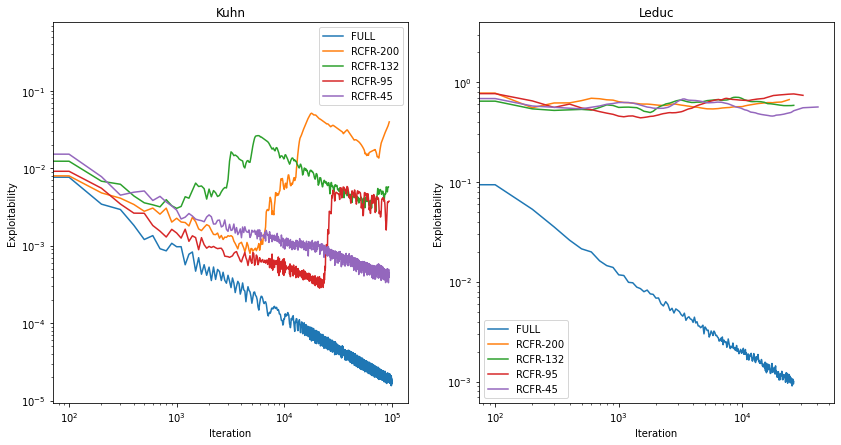

In [26]:
kuhn_logs = [("./logs/rcfr/cfr_kuhn_0.csv", "FULL"),
             ("./logs/rcfr/rcfr_kuhn_0.csv", "RCFR-200"),
             ("./logs/rcfr/rcfr_kuhn_132_0.csv", "RCFR-132"),
             ("./logs/rcfr/rcfr_kuhn_95_0.csv", "RCFR-95"),
             ("./logs/rcfr/rcfr_kuhn_45_0.csv", "RCFR-45")
            ]

leduc_logs = [("./logs/rcfr/cfr_leduc_0.csv", "FULL"),
             ("./logs/rcfr/rcfr_leduc_0.csv", "RCFR-200"),
             ("./logs/rcfr/rcfr_leduc_132_0.csv", "RCFR-132"),
             ("./logs/rcfr/rcfr_leduc_95_0.csv", "RCFR-95"),
             ("./logs/rcfr/rcfr_leduc_45_0.csv", "RCFR-45")
            ]

kuhn_dat = load_batch(kuhn_logs).loc[::100]
leduc_dat = load_batch(leduc_logs).loc[::100]

log_log = True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = kuhn_dat.plot(title="Kuhn", logy=log_log, logx=log_log, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax = leduc_dat.plot(title="Leduc", logy=log_log, logx=log_log, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")

# FSP & NFSP

[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

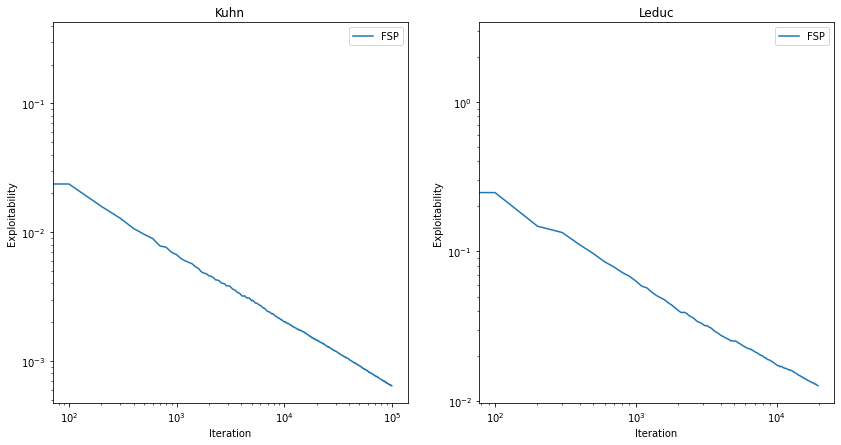

In [37]:
kuhn_logs = [("./logs/nfsp/xfp_kuhn_0.csv", "FSP")
            ]

leduc_logs = [("./logs/nfsp/xfp_leduc_0.csv", "FSP")
            ]

kuhn_dat = load_batch(kuhn_logs)
leduc_dat = load_batch(leduc_logs)

log_log = True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = kuhn_dat.plot(title="Kuhn", logy=log_log, logx=log_log, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax = leduc_dat.plot(title="Leduc", logy=log_log, logx=log_log, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")

(0.01, 10)

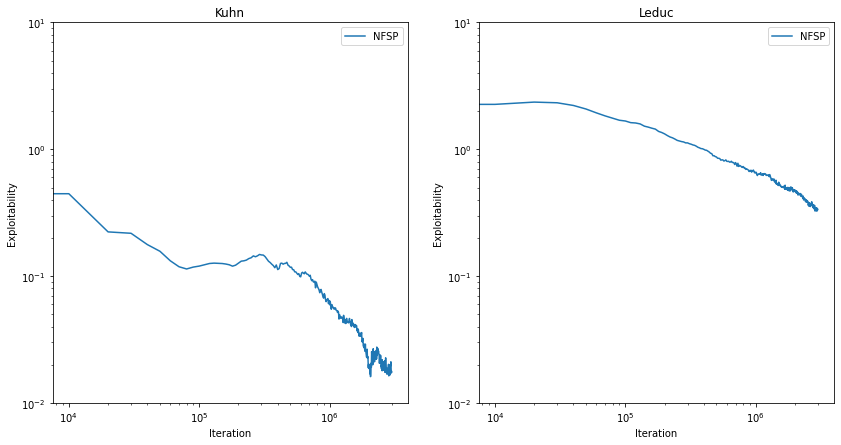

In [38]:
kuhn_logs = [("./logs/nfsp/nfsp_kuhn_0.csv", "NFSP")
            ]

leduc_logs = [("./logs/nfsp/nfsp_leduc_0.csv", "NFSP")
            ]

kuhn_dat = load_batch(kuhn_logs)
leduc_dat = load_batch(leduc_logs)

log_log = True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = kuhn_dat.plot(title="Kuhn", logy=log_log, logx=log_log, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))
ax = leduc_dat.plot(title="Leduc", logy=log_log, logx=log_log, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))

# DeepCFR

(0.01, 10)

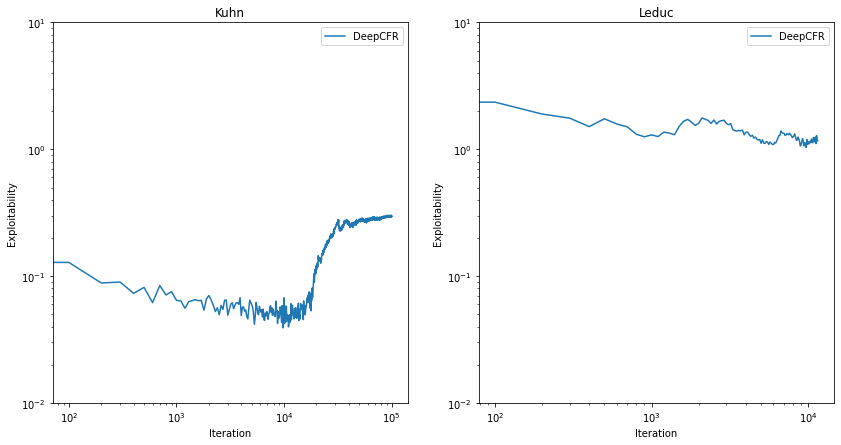

In [31]:
kuhn_logs = [("./logs/deep_cfr/deep_cfr_kuhn_0.csv", "DeepCFR")
            ]

leduc_logs = [("./logs/deep_cfr/deep_cfr_leduc_0.csv", "DeepCFR")
            ]

kuhn_dat = load_batch(kuhn_logs)
leduc_dat = load_batch(leduc_logs)

log_log = True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = kuhn_dat.plot(title="Kuhn", logy=log_log, logx=log_log, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))
ax = leduc_dat.plot(title="Leduc", logy=log_log, logx=log_log, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))